In [ ]:
# import threading
# import time
# import random
# import queue

# # Thread-safe queue for each wheel
# wheel_queues = {
#     'front_left': queue.Queue(),
#     'front_right': queue.Queue(),
#     'rear_left': queue.Queue(),
#     'rear_right': queue.Queue()
# }

# def simulate_encoder(wheel_name):
#     """Generate random encoder readings for one wheel"""
#     while True:
#         # Random encoder value (0-1000 ticks)
#         reading = random.randint(0, 1000)
#         timestamp = time.time()

#         # Put data in thread-safe queue
#         wheel_queues[wheel_name].put((timestamp, reading))

#         # Simulate real sensor frequency (~100Hz)
#         time.sleep(0.01)

# # Start threads for all 4 wheels
# threads = []
# for wheel in wheel_queues.keys():
#     thread = threading.Thread(target=simulate_encoder, args=(wheel,), daemon=True)
#     thread.start()
#     threads.append(thread)

# # Main loop to process data at 50Hz
# print("Starting odometry data ingestion...")
# try:
#     while True:
#         # Get latest readings from all wheels
#         current_readings = {}
#         for wheel, q in wheel_queues.items():
#             if not q.empty():
#                 current_readings[wheel] = q.get()

#         # Print current state (for debugging)
#         if current_readings:
#             print(f"Readings: {current_readings}")

#         # Output at 50Hz
#         time.sleep(0.02)

# except KeyboardInterrupt:
#     print("Stopping system...")

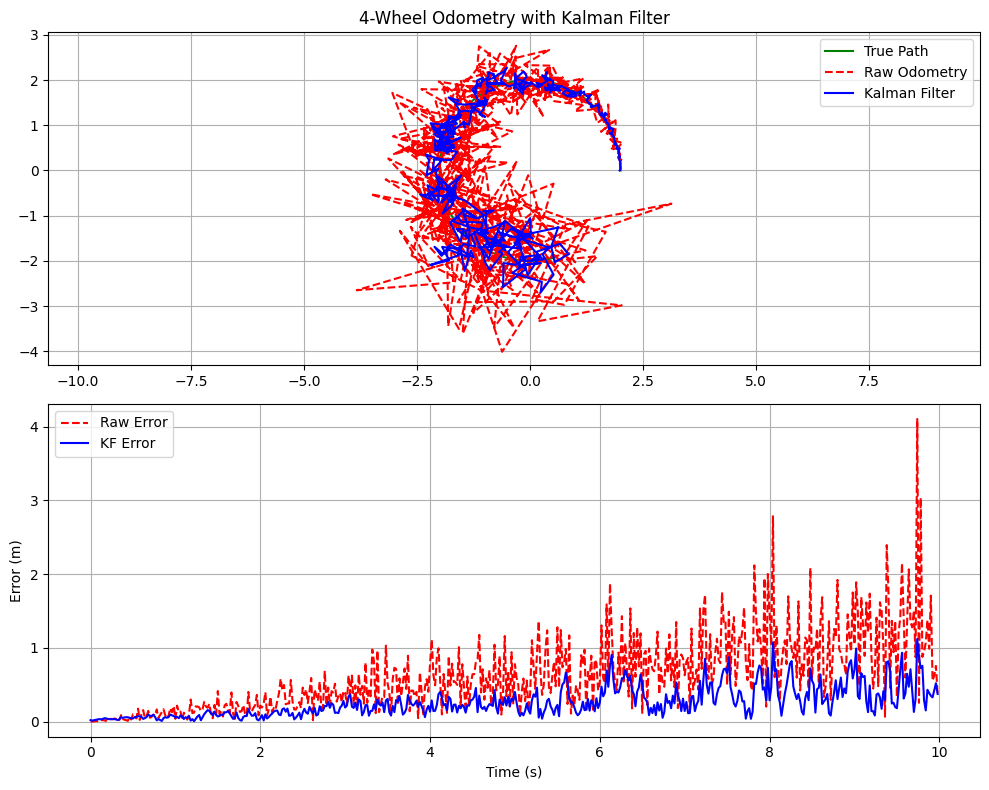

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simple Kalman Filter class
class KalmanFilter:
    def __init__(self):
        self.x = np.zeros(2)  # [x, y]
        self.P = np.eye(2) * 10  # uncertainty
        self.F = np.eye(2)    # state transition
        self.H = np.eye(2)    # measurement matrix
        self.R = np.eye(2) * 0.1  # measurement noise
        self.Q = np.eye(2) * 0.01 # process noise

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(2) - K @ self.H) @ self.P

dt = 0.02  # 50Hz
kf = KalmanFilter()

times, true_pos, raw_pos, est_pos = [], [], [], []
x_true = y_true = x_raw = y_raw = 0

for t in np.arange(0, 10, dt):
    times.append(t)

    x_true = 2 * np.cos(0.5 * t)
    y_true = 2 * np.sin(0.5 * t)

    x_raw = x_true + np.random.randn() * 0.1 * t
    y_raw = y_true + np.random.randn() * 0.1 * t

    kf.predict()
    kf.update(np.array([x_raw, y_raw]))

    true_pos.append([x_true, y_true])
    raw_pos.append([x_raw, y_raw])
    est_pos.append([kf.x[0], kf.x[1]])

plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.plot([p[0] for p in true_pos], [p[1] for p in true_pos], 'g-', label='True Path')
plt.plot([p[0] for p in raw_pos], [p[1] for p in raw_pos], 'r--', label='Raw Odometry')
plt.plot([p[0] for p in est_pos], [p[1] for p in est_pos], 'b-', label='Kalman Filter')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title('4-Wheel Odometry with Kalman Filter')

plt.subplot(212)
raw_error = [np.sqrt((raw_pos[i][0]-true_pos[i][0])**2 + (raw_pos[i][1]-true_pos[i][1])**2)
             for i in range(len(times))]
kf_error = [np.sqrt((est_pos[i][0]-true_pos[i][0])**2 + (est_pos[i][1]-true_pos[i][1])**2)
            for i in range(len(times))]
plt.plot(times, raw_error, 'r--', label='Raw Error')
plt.plot(times, kf_error, 'b-', label='KF Error')
plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')

plt.tight_layout()
plt.show()

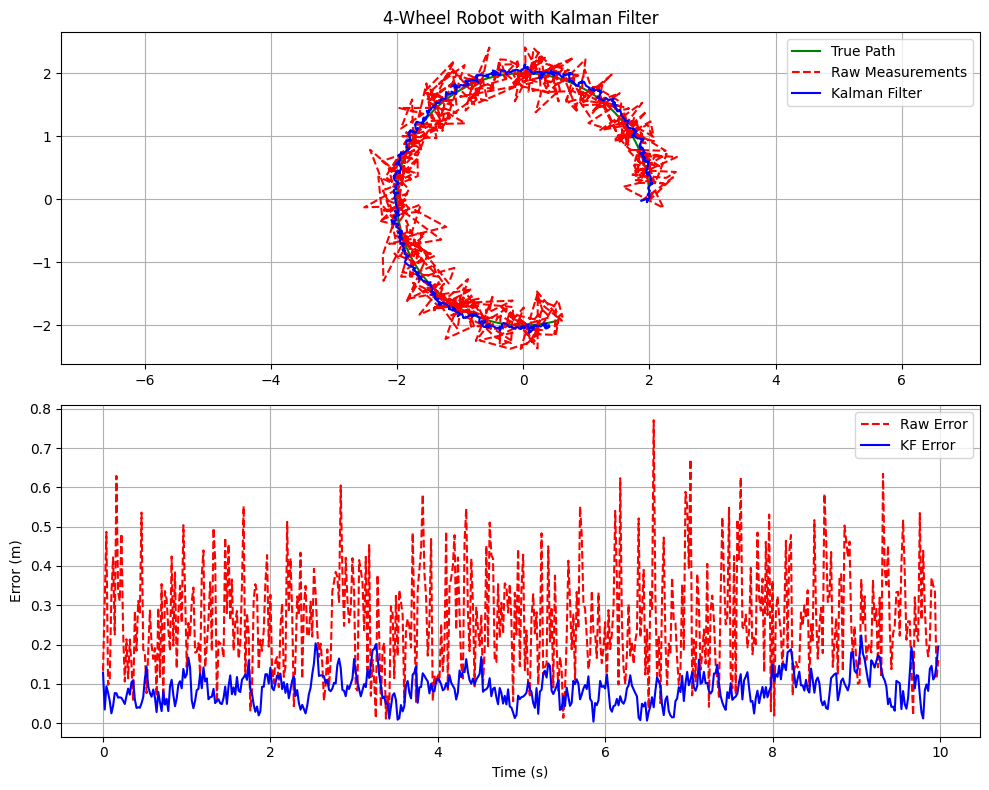

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleKalmanFilter:
    def __init__(self, wheel_base=0.3, wheel_radius=0.05):
        
        self.wheel_base = wheel_base
        self.wheel_radius = wheel_radius
        
        # State: [x, y, theta]
        self.x = np.zeros(3)  # x, y, heading
        self.P = np.eye(3) * 1.0  # uncertainty
        
        # Matrices for linear Kalman filter
        self.F = np.eye(3)    # state transition
        self.H = np.eye(3)    # measurement matrix
        self.R = np.eye(3) * 0.1  # measurement noise
        self.Q = np.eye(3) * 0.01 # process noise

    def predict(self, delta_left, delta_right):
        delta_center = (delta_left + delta_right) / 2
        
    
        delta_theta = (delta_right - delta_left) / self.wheel_base
        
        # Update state using kinematics
        x, y, theta = self.x
        
      
        x_new = x + delta_center * np.cos(theta + delta_theta/2)
        y_new = y + delta_center * np.sin(theta + delta_theta/2)
        theta_new = theta + delta_theta
        
        self.x = np.array([x_new, y_new, theta_new])
        
        # Update uncertainty
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, measurement):
        """Update state  """
        y = measurement - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(3) - K @ self.H) @ self.P

dt = 0.02  # 50Hz
wheel_base = 0.6  # 60cm 
wheel_radius = 0.05  # 5cm 
kf = SimpleKalmanFilter(wheel_base, wheel_radius)

times, true_pos, raw_pos, est_pos = [], [], [], []
x_true = y_true = theta_true = 0

for t in np.arange(0, 10, dt):
    times.append(t)
    
    #  ircular motion
    x_true = 2 * np.cos(0.5 * t)
    y_true = 2 * np.sin(0.5 * t)
    theta_true = 0.5 * t
    
    # Calculate true wheel movementtt
    v_linear = 1.0  # m/s
    omega = 0.5    # rad/s
    
    # Wheel speeds for differential drive
    v_left = v_linear - (wheel_base/2) * omega
    v_right = v_linear + (wheel_base/2) * omega
    
    delta_left_true = v_left * dt
    delta_right_true = v_right * dt
    
    encoder_noise = 0.2  #  noise
    
    # Left wheels (front and rear) - similar readings
    left_front = delta_left_true / wheel_radius + np.random.randn() * encoder_noise
    left_rear = delta_left_true / wheel_radius + np.random.randn() * encoder_noise
    
    # Right wheels (front and rear) - similar readings
    right_front = delta_right_true / wheel_radius + np.random.randn() * encoder_noise
    right_rear = delta_right_true / wheel_radius + np.random.randn() * encoder_noise
    
    # Process encoder values: average left and right sides
    avg_left_encoder = (left_front + left_rear) / 2
    avg_right_encoder = (right_front + right_rear) / 2
    
    #  distance traveled
    delta_left = avg_left_encoder * wheel_radius
    delta_right = avg_right_encoder * wheel_radius
    

    kf.predict(delta_left, delta_right)
    
    
    measurement = np.array([x_true, y_true, theta_true]) + np.random.randn(3) * 0.1
    
    kf.update(measurement)
    

    true_pos.append([x_true, y_true])
    raw_pos.append([x_true + np.random.randn()*0.2, y_true + np.random.randn()*0.2])
    est_pos.append([kf.x[0], kf.x[1]])

# Plot results
plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.plot([p[0] for p in true_pos], [p[1] for p in true_pos], 'g-', label='True Path')
plt.plot([p[0] for p in raw_pos], [p[1] for p in raw_pos], 'r--', label='Raw Measurements')
plt.plot([p[0] for p in est_pos], [p[1] for p in est_pos], 'b-', label='Kalman Filter')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title('4-Wheel Robot with Kalman Filter')

plt.subplot(212)
raw_error = [np.sqrt((raw_pos[i][0]-true_pos[i][0])**2 + (raw_pos[i][1]-true_pos[i][1])**2)
             for i in range(len(times))]
kf_error = [np.sqrt((est_pos[i][0]-true_pos[i][0])**2 + (est_pos[i][1]-true_pos[i][1])**2)
            for i in range(len(times))]
plt.plot(times, raw_error, 'r--', label='Raw Error')
plt.plot(times, kf_error, 'b-', label='KF Error')
plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')

plt.tight_layout()
plt.show()